# 语义识别（Text Classification）

使用循环神经网络进行电影评论判断是正面还是负面评论. `keras.preprocessing` 已经不再推荐使用了，用 `keras.layers` 中的函数进行替代. 参考官方教程 [Text Classification - Tutorials](https://www.tensorflow.org/text/tutorials/text_classification_rnn?hl=en).

## 数据集

使用keras中的[IMDB电影评论数据集](https://tensorflow.google.cn/datasets/catalog/imdb_reviews)（现已整合到tensorflow_dataset(tfds)中，可直接读取为dataset格式），包含 $50000$ 条评论来自[IMDB](https://www.imdb.com/)电影数据网站，其中 $25000$ 为训练集大小，$25000$ 为验证集大小. 并且将每个单词以其出现频率进行编号，如 $3$ 代表的单词表示它是在全部单词中出现频率第 $3$ 高的.

- `tfds.load(name, split=None with_info=False, as_supervised=False)`：`name` 为数据集名称，从[该网站](https://tensorflow.google.cn/datasets/catalog/overview#all_datasets)可看到全部数据集；`split` 可手动划分整个数据集为训练集和验证集；`with_info=True` 会返回一个tuple：`(Dataset, DatasetInfo)`，第一个为数据集大小，第二个为数据集的相关信息；`as_supervised` 会将根据数据集信息划分数据集为训练集和验证集，可以从数据集的相关网站看到划分介绍.

这里用的数据集网站为：[IMDB电影评论数据集](https://tensorflow.google.cn/datasets/catalog/imdb_reviews).

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
ds, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True) 
info  # 可以看到数据集的相关信息

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset.
    This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_path='~\\tensorflow_datasets\\imdb_reviews\\plain_text\\1.0.0',
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=25000, num_shards=1>,
     

In [3]:
train, test = ds['train'], ds['test']
train.element_spec  # 可以看出每个样本的特征是string类，标签为int类

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
for x, y in train:
    print('文本：{}\n标签：{}'.format(x.numpy(), y.numpy()))
    break

文本：b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
标签：0


可以看出数据集还没有划分为batch，下面进行划分.

In [5]:
# prefetch为训练模型时预处理数据的大小.
train = train.shuffle(10000).batch(64)#.prefetch(tf.data.AUTOTUNE)
test = test.batch(64)#.prefetch(tf.data.AUTOTUNE)

In [6]:
for x, y in train:
    print('训练集和验证集大小：', x.shape, y.shape)
    print('文本：{}\n标签：{}'.format(x.numpy()[:3], y.numpy()[:3]))
    break

训练集和验证集大小： (64,) (64,)
文本：[b'I saw this with few expectations and absolutely loved it! Bend it like Beckham is a fairly typical coming-of-age movie about a fairly atypical girl. This is Parminder Nagra ("ER")\'s breakout role, playing Jess, a teenager in England who is caught between her traditional Indian family and her love of football (that\'s soccer to us North Americans). And even though she\'s actually much older than her character, she plays the role pitch-perfect.<br /><br />This is a movie about friendship - specifically Jess\'s friendship with Jules (Keira Knightley), her teammate who is also going through family issues, especially with her mom, who wears purple nail polish and little bows on her shoes, and who wants Jules to be more feminine, wear lacy underwear and flirt with boys and is terrified that playing sports means her daughter is a lesbian. Jules and Jess both love playing the game and have issues trying to convince their families to let them go after their dreams.

## 单词编码

需要对每个单词进行编码处理，从而将一个句子转化为向量的形式，这里使用tensorflow中的一种层就能很方便完成：

- `encoder = tf.keras.layers.TextVectorization(max_tokens=None)`：`max_tokens` 正整数，为转换的最大单词个数，由于要有一个统一记录未编号的单词，所以有效记录个数为 `max_tokens-1` 个（其实好像是 `max_tokens-2` 个有两个没有用的字符）.

输入为一句话（英文）构成的字符串

1. 每个句子均转为小写，再去掉所有标点.
2. 根据每个单词分离为不同子串.
3. 对子串进行编号.（根据单词出现频率从大到小进行编号）
4. 将每个输入的子串用编号表示，转化为tensor形式输出.

- `encoder.adapt(data)`：使用该类下的 `adapt()` 是必要的初始化方法，建立单词索引库，`data` 为训练集中全部的特征（句子），这样就可以预先得到每个此对应的数据.（有了这一步才能对 `encoder()` 进行调用）

- `encoder.get_vocabulary()`：返回当前层下的全部单词.

In [7]:
encoder = layers.TextVectorization(max_tokens=1000)  # 只对前1000个出现频率最高的词进行编号
#encoder = layers.TextVectorization()  # 不设定max_tokens就会对全部单词建立索引
encoder.adapt(train.map(lambda x, y: x))  # 取出全部的语句，建立单词索引库

In [8]:
vocab = np.array(encoder.get_vocabulary())
print('词汇总数：', vocab.shape)
print(vocab[:10])  # 查看前10个
print('对应索引：', dict(zip(list(range(10)), vocab[:10])))
print('"the a a and the" 转化为索引：', encoder("the a a and the").numpy())

词汇总数： (1000,)
['' '[UNK]' 'the' 'and' 'a' 'of' 'to' 'is' 'in' 'it']
对应索引： {0: '', 1: '[UNK]', 2: 'the', 3: 'and', 4: 'a', 5: 'of', 6: 'to', 7: 'is', 8: 'in', 9: 'it'}
"the a a and the" 转化为索引： [2 4 4 3 2]


进行单词和索引间的相互转化. 可以看到，转换回来的文本与原文并不相同，出现了 `[UNK]` 字符，指的应该就是没有加载到单词库中的单词（出现频率较低）；而且文本都转换为小写了.

In [9]:
x, y = next(iter(train))  # 从训练集中提取出一个样本
print('原始数据: ', x[0].numpy())
print('往返后的数据：', ' '.join(vocab[encoder(x[0])]))  # encoder(x[0]) 为转化后的结果，vocab 为对应单词库，' '.join 可以将转化后结果用' '连接起来.

原始数据:  b'While flipping through the channels on a late Saturday night, my friends and I stumbled across this film. First of all, Irish actor Pierce Brosnan as a Native American? Seriously?! His accent was breaking through so much, although his character was apparently Scottish. Next, I was stunned to find that this film was made after he had already played James Bond/Agent 007 at least twice. This movie plays up the stereotypes, with the inspiring professor figure. The girl who played Pony should be paid to keep her mouth shut. And, this film won an award? I cannot believe it. Brosnan is an attractive man, but we seriously wanted to gauge our eyes out after watching this for just 10 seconds. We switched from "Kicking and Screaming" to this, and we wanted to switch back. We watched the 1995 children\'s classic "The Indian in the Cupboard" earlier in the night, which also discussed the Iroquois. The following line represents our desire to run away: "Take me outside, earth grasper." From 

## 循环神经网络（RNN）框架

![网络结构示意图](https://s1.ax1x.com/2022/07/21/jLQbj0.png)

主要由五个部分构成：

1. 输入层：一个string类的句子，包含多个单词.
2. 文本向量化：将句子拆分为单词，将每个单词映射到对应的正整数索引上.（转化为one-hot型向量）
3. 嵌入（Embedding）：将离散型（one-hot型，取值为0或1）向量转化为连续型（取值在 $[0,1]$ 区间中），便于全连接层的训练. 通过足够多的训练，可以使得具有相近含义的词距离更近（不是很清楚）. 可视化效果请见 [TensorFlow - Embedding projector](http://projector.tensorflow.org/).
4. 这里用的是RNN的一个变种，Bidirectional Recurrent Neural Networks（BRNN, 双向循环神经网络），就是由两个输入方向相反的简单循环神经网络（隐藏层）构成，最后都连接到输出中. 两个隐藏层的输入分别是将特征从正向输入一遍，和从逆向输入一遍，这样可以使得神经网络具有过多的信息（获得过去和未来的状态，maybe），使其更加灵活.

- BRNN的优点：开头的传入信号，无需经过整个神经网络后才能输出来，这样会使得信号具有的性质被减弱. 加入反向隐藏层可以使开头的信号更快地被输出出来.

- BRNN的缺点：实时性效率降低，每次将新的单词添加到末尾时，需要重新执行反向隐藏层（无法流式输出）.

5. 在输出层后，使用全连接神经网络作为分类器.

用到以下的几种新的 `layers`：

- `tf.keras.layers.Embedding(input_dim, output_dim, mask_zero=False)`：`input_dim` 为单词库的大小；`output_dim` 为输出的维数；`mask_zero` 为布尔型，使用可变长的循环神经网络时需要用到，会将索引为0的作为掩码，在后续网络中将跳过处理（类似dropout），同时这需要后续网络都支持掩码功能. 这样做还需要一个条件，即不能将0作为特定单词的索引，而上述单词库中可以看到编号就是从1开始的，正好满足条件.

- `tf.keras.layers.Bidirectional(layer)`：`layer` 为一种层，可以为 `LSTM, GRU`，这里就是用标准的LSTM(Long Short Term Memory).

- `tf.keras.layers.LSTM(units)`：`units` 为一个正整数，表示输出向量的维数.

In [10]:
model = keras.Sequential([
    encoder,
    layers.Embedding(encoder.vocabulary_size(), 64, mask_zero=True),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model.compile(optimizer='adam',
              loss=keras.losses.BinaryCrossentropy(from_logits=True),  # 使用from_logits可以将输入进行压缩，避免溢出
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 138,369
Trainable params: 138,369
Non-trainable params: 0
_________________________________________________________________


这里再解释一下掩码操作，在一个batch中，由于每个样本的特征所含的单词个数不同，导致特征向量的维数不同，所以需要将低维的向量统一到高维，但又不对低维向量多余的部分进行处理，则这里就用到掩码，掩码的作用是可以传递一个判断是否是原有数据的布尔数组给layer，使得layer可以对那些填充的部分不进行处理.

所以掩码操作可以保证低维的和高维的放在一起计算，低维计算出的结果都是相同的. 下面这个例子就是验证这个操作的.

In [11]:
# 预测没有掩码操作的结果

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print('没有掩码: ', predictions[0])

# 和一个更长的字符串放在一起，掩码就起到了作用，保证预测结果一致

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print('有掩码: ', predictions[0])

没有掩码:  [0.01529623]
有掩码:  [0.01529623]


## 模型训练&验证

In [12]:
history = model.fit(train, validation_data=test, epochs=10, validation_steps=30)  

# validation_steps表示每次计算验证集使用多少个batch，每次可以只用部分验证集做一个验证

Epoch 1/10
391/391 [==============================] - 31s 67ms/step - loss: 0.4530 - accuracy: 0.7687 - val_loss: 0.3724 - val_accuracy: 0.8526
Epoch 2/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3443 - accuracy: 0.8496 - val_loss: 0.3689 - val_accuracy: 0.8068
Epoch 3/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3217 - accuracy: 0.8592 - val_loss: 0.3452 - val_accuracy: 0.8359
Epoch 4/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3044 - accuracy: 0.8665 - val_loss: 0.3418 - val_accuracy: 0.8375
Epoch 5/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3028 - accuracy: 0.8663 - val_loss: 0.3743 - val_accuracy: 0.8344
Epoch 6/10
391/391 [==============================] - 25s 63ms/step - loss: 0.2799 - accuracy: 0.8784 - val_loss: 0.3682 - val_accuracy: 0.8448
Epoch 7/10
391/391 [==============================] - 24s 63ms/step - loss: 0.2611 - accuracy: 0.8840 - val_loss: 0.3553 - val_accuracy:

In [13]:
def plot_history(history, metric):  # 定义一个训练过程中绘制训练集和验证集关于metric变量的关系图，metric为accuracy或loss
    plt.plot(history.history[metric], label='Training ' + metric)
    plt.plot(history.history['val_'+metric], label='Validation ' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()

def check(model, history):  # 用于绘制训练过程中的accuracy和loss
    test_loss, test_acc = model.evaluate(test)
    print('整个验证集的Loss: ', test_loss)
    print('整个验证集的Accuracy', test_acc)
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plot_history(history, 'accuracy')
    plt.subplot(1, 2, 2)
    plot_history(history, 'loss')
    

391/391 [==============================] - 10s 25ms/step - loss: 0.3750 - accuracy: 0.8381
整个验证集的Loss:  0.37499067187309265
整个验证集的Accuracy 0.8381199836730957


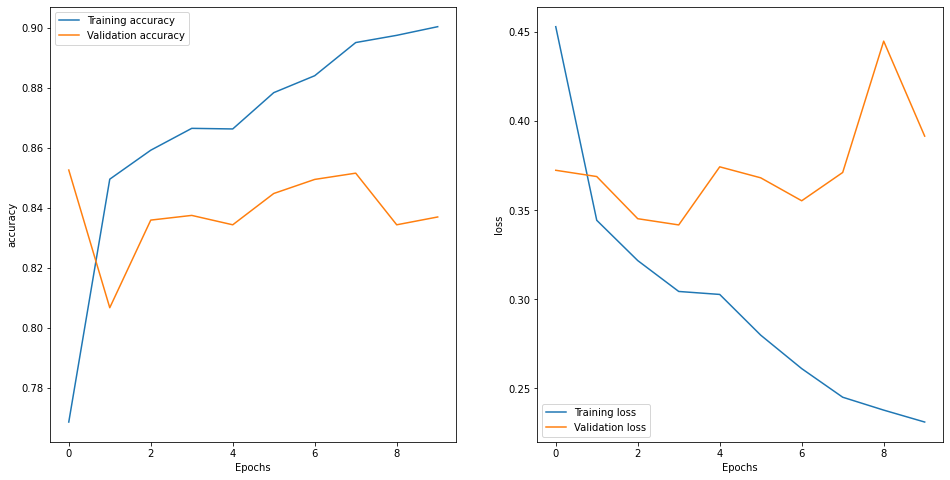

In [14]:
check(model, history)

## 模型优化

从上图可以看出，每次更新幅度太大，通过减小学习率是变化幅度减小，更加稳定.

In [15]:
model1 = keras.Sequential([
    encoder,
    layers.Embedding(encoder.vocabulary_size(), 64, mask_zero=True),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model1.compile(optimizer=keras.optimizers.Adam(1e-4),  # 减小学习率（步长），默认为1e-3
               loss=keras.losses.BinaryCrossentropy(from_logits=True),  # 使用from_logits可以将输入进行压缩，避免溢出
               metrics=['accuracy'])
history1 = model1.fit(train, validation_data=test, epochs=10, validation_steps=30)  

Epoch 1/10
391/391 [==============================] - 31s 67ms/step - loss: 0.6457 - accuracy: 0.5679 - val_loss: 0.5579 - val_accuracy: 0.6672
Epoch 2/10
391/391 [==============================] - 25s 63ms/step - loss: 0.4337 - accuracy: 0.7930 - val_loss: 0.4153 - val_accuracy: 0.7943
Epoch 3/10
391/391 [==============================] - 24s 62ms/step - loss: 0.3633 - accuracy: 0.8405 - val_loss: 0.3594 - val_accuracy: 0.8432
Epoch 4/10
391/391 [==============================] - 24s 62ms/step - loss: 0.3333 - accuracy: 0.8561 - val_loss: 0.3499 - val_accuracy: 0.8568
Epoch 5/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3162 - accuracy: 0.8650 - val_loss: 0.3328 - val_accuracy: 0.8438
Epoch 6/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3088 - accuracy: 0.8683 - val_loss: 0.3242 - val_accuracy: 0.8526
Epoch 7/10
391/391 [==============================] - 24s 62ms/step - loss: 0.3024 - accuracy: 0.8716 - val_loss: 0.3273 - val_accuracy:

391/391 [==============================] - 10s 25ms/step - loss: 0.3219 - accuracy: 0.8642
整个验证集的Loss:  0.3219233751296997
整个验证集的Accuracy 0.8641600012779236


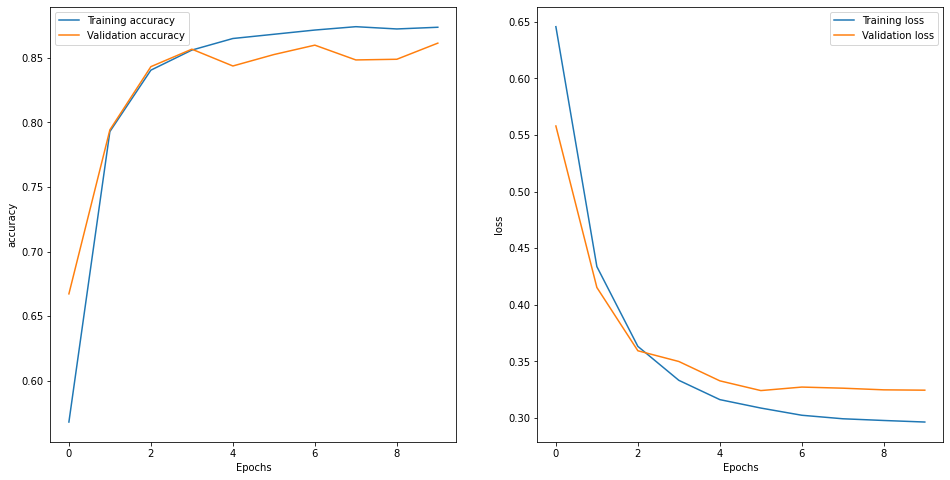

In [16]:
check(model1, history1)

## 自定义预测样本

下面预测一些自己设定的句子. 如果预测值为正数则是**正面的**，否则是**负面的**.

In [17]:
text = ["That movie was so awesone! I really loved it and would watch it again because it was amazingly great!"
        "That movie was just amazing, so amazing!!",
        "The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.",
        "So terrible!",
        "Just loss my time!",
        "Boring and uninterstin.",
        "That movie sucked. I hated it and wouldn't watch it again. Was one of the worst things I've ever watched"]
predict = model1.predict(np.array(text))
print(predict)

[[ 3.270603  ]
 [ 0.6403193 ]
 [-1.4261589 ]
 [-0.01271313]
 [-1.3495797 ]
 [-2.5157082 ]]
